In [1]:
import itertools
import pathlib
import pyam

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# these functions can be found in utils.py in this same directory
from utils import (
    make_quantiles,
    make_sequestration_plot_data,
    sequestration_plot,
    share_of_cdr_data,
)

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

# Load Data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
paper_data = pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
])

In [4]:
ar6_data = pd.read_csv(data_path / 'AR6_Scenarios_Database_World_v1.0.csv')
ar6_data = ar6_data[ar6_data.Variable.isin(['Emissions|CO2|AFOLU'])]

In [5]:
df = pyam.IamDataFrame(pd.concat([paper_data, ar6_data]))
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators for 914 out of 1874 scenarios


In [6]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

In [7]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only from 2020',
 'Cumulative AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Cumulat

# Panel 1A

In [51]:
variables = [
    'Emissions|CO2|AFOLU',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
]

data = pyam.concat([
    make_quantiles(df, v, cat)
    for v, cat in itertools.product(variables, categories_to_temp.keys())
])

In [52]:
def afolu_line_plot(data, variables, cat, ax=None, years=range(1990, 2051), color='variable'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.25*', '*0.75*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color=color, fill_between=True, ax=ax, alpha=0.1, legend=False) #  cmap='PiYG_r',
    )
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.5*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color=color, ax=ax)  # cmap='PiYG_r',
    )
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-len(variables):], l[-len(variables):])
    return ax

In [53]:
color_map = {
    'Emissions|CO2|AFOLU': '#' + 'c' * 6,
    'LULUCF Emissions - BK/IAM Reporting Convensions': '#33701a',
    'LULUCF Emissions - NGHGI Reporting Conventions': '#a3176d', 
}
pyam.run_control().update({'color': {'variable': color_map}})

In [54]:
error = pd.read_excel(data_path / 'LUC_uncertainty_AR6_reanalysis.xlsx', sheet_name='Fig1AB')

<AxesSubplot:>

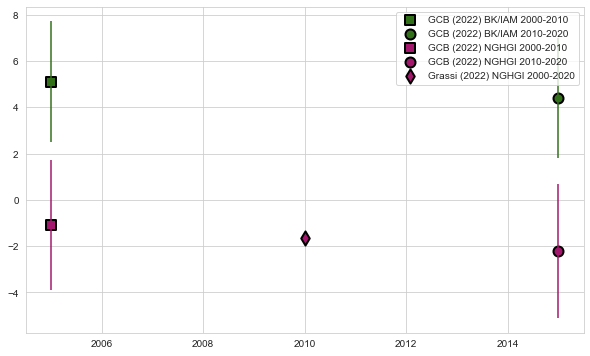

In [55]:
def add_eluc_history(error, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    colors = {
        'BK/IAM': '#33701a',
        'NGHGI': '#a3176d', 
    }
    markers = {
        '2000-2010': 's',
        '2010-2020': 'o', 
        '2000-2020': 'd',
    }
    for i, row in error.iterrows():
        label = ' '.join((row['label'], row['emissions'], row['period']))
        ax.scatter(row['plot_year'], row['mean'], marker=markers[row['period']],  label=label, 
                   color=colors[row['emissions']], s=100, edgecolor='k', linewidths=2)
        ax.errorbar(row['plot_year'], row['mean'], row['std'], color=colors[row['emissions']])
    ax.legend()
    return ax

add_eluc_history(error)

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


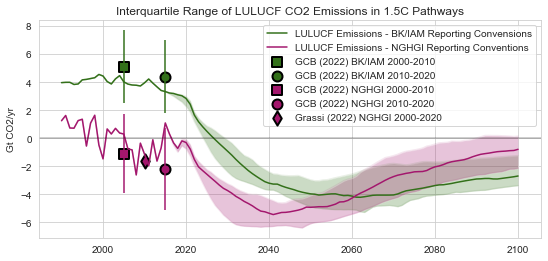

In [56]:
cat = 'C1'

variables = {
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'LULUCF Emissions - BK/IAM Reporting Convensions',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'LULUCF Emissions - NGHGI Reporting Conventions', 
}
fig, ax = plt.subplots(figsize=(9, 4))
afolu_line_plot(data.rename(variable=variables), variables.values(), cat, years=range(1990, 2101), ax=ax)
add_eluc_history(error, ax=ax)
ax.axhline(0, c='k', alpha=0.25)

ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')
h, l = ax.get_legend_handles_labels()
ax.legend(h[-7:], l[-7:])

fig.savefig('./files/fig1a1.pdf')

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


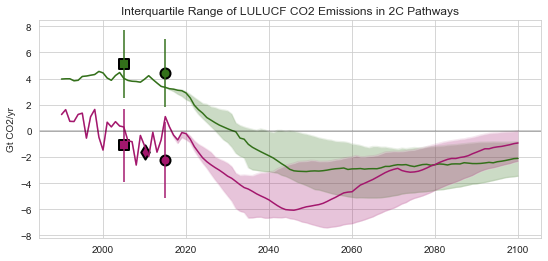

In [57]:
cat = 'C3'

variables = {
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'LULUCF Emissions - BK/IAM Reporting Convensions',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'LULUCF Emissions - NGHGI Reporting Conventions', 
}
fig, ax = plt.subplots(figsize=(9, 4))
afolu_line_plot(data.rename(variable=variables), variables.values(), cat, years=range(1990, 2101), ax=ax)
add_eluc_history(error, ax=ax)
ax.axhline(0, c='k', alpha=0.25)

ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')
ax.legend().remove()

fig.savefig('./files/fig1a2.pdf')

# Panel 1B

In [58]:
error = pd.read_excel(data_path / 'LUC_uncertainty_AR6_reanalysis.xlsx', sheet_name='Fig1C')
error

,label,period,plot_year,mean,std
0,Grassi (2023),2000-2020,2009,6.7,2.5
1,GCB (2022),2000-2020,2011,6.4,1.2
2,OSCAR (this study),2000-2020,2012,4.4,1.0


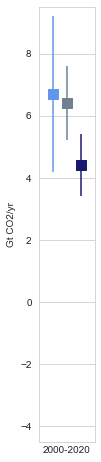

In [59]:
fig, ax = plt.subplots(figsize=(1, 8))
markers = {
    '2000-2020': 's',
    '2000-2010': 'd',
    '2005-2015': 'o', 
    '2010-2020': '*',
}
colors = {
    'GCB (2022)': 'slategrey',
    'Grassi (2021)': 'royalblue', 
    'Grassi (2023)': 'cornflowerblue',
    'OSCAR (this study)': 'midnightblue',
}
for i, row in error.iterrows():
    label = ' '.join((row['label'], row['period']))
    ax.scatter(-1 + i, row['mean'], marker=markers[row['period']],  label=label, color=colors[row['label']], s=100)
    ax.errorbar(-1 + i, row['mean'], row['std'], color=colors[row['label']])

# set xticks
ax.set_xlim((-2, 2))
ax.set_xticks([])
ax.set_xlabel('2000-2020')

# conform with below plot
ax.set_ylabel('Gt CO2/yr')
plt.grid(axis='x', visible=False)

## This block should be commented/uncommented to get adobe-ready versions
#ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])

# harmonize ylim
ax.set_ylim(-4.5, 9.5)

fig.savefig('./files/fig1b1.pdf', bbox_inches='tight')

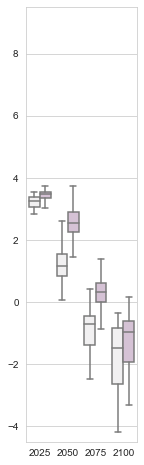

In [62]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
]
name = 'NGHGI LULUCF Gap'
fig, ax = plt.subplots(figsize=(2, 8))
(
    df
    .filter(region='World', variable=variables)
    .filter(Temperature=categories_to_temp.values())
    .filter(year=range(2025, 2101, 25))
    .subtract(variables[0], variables[1], name=name, ignore_units='Mt CO2/yr')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .box(color='thistle', by='Temperature', ax=ax, showfliers=False)
)
ax.set_xlabel('')

## This block should be commented/uncommented to get adobe-ready versions
#ax.set_title(name)
#ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])
ax.legend().remove()

# conform with previous plot
ax.set_ylabel('')

# harmonize ylim
ax.set_ylim(-4.5, 9.5)

fig.savefig('./files/fig1b2.pdf', bbox_inches='tight')

Text(0.5, 0, '')

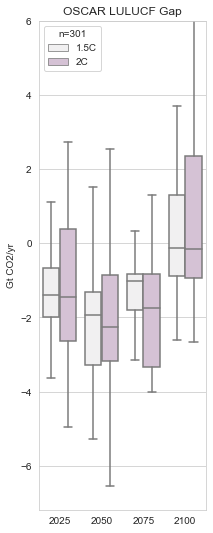

In [18]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
    'Emissions|CO2|AFOLU', 
]
name = 'OSCAR LULUCF Gap'
fig, ax = plt.subplots(figsize=(3, 9))
(
    df
    .filter(region='World', variable=variables)
    .filter(Temperature=categories_to_temp.values())
    .filter(year=range(2025, 2101, 25))
    .subtract(variables[0], variables[1], name=name, ignore_units='Mt CO2/yr')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .box(color='thistle', by='Temperature', ax=ax, showfliers=False)
)
ax.set_title(name)
ax.set_ylim(None, 6)
ax.set_xlabel('')